# **Load The Packges**

- Torchvision models for SSD-based object detection
- Albumentations for image augmentation
- Matplotlib for visualization
- Shapely for handling geometric data
- OpenCV and PIL for image processing
- Torch and NumPy for deep learning operations
- Pandas for handling tabular data
- Utility libraries for logging, file handling, and progress tracking

In [1]:
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.ssd import SSDClassificationHead
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib.patches import Polygon, Rectangle
from torchvision import transforms as torchtrans  
from torchvision.models.detection import _utils
from torch.optim.lr_scheduler import StepLR
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import albumentations as Alb
from shapely.wkt import loads
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import random
import torch
import glob
import utils_
import json
import time
import cv2
import os

# **Read the data**

In [2]:
# Dictionary mapping damage categories to numerical labels for classification
LABEL_MAP = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4
}

# Function to extract bounding boxes and class labels from a JSON annotation file
def get_boxes_classes(path, use_rectangles=True):
    """
    Reads bounding box and classification data from a JSON file.
    
    Args:
        path (str): Path to the JSON annotation file.
        use_rectangles (bool): If True, extracts rectangular bounding boxes; otherwise, extracts polygon coordinates.

    Returns:
        tuple: (list of bounding boxes, list of corresponding labels)
    """
    with open(path, 'r') as f:
        file = json.load(f)['features']['xy']
    
    boxes = []  # Store bounding boxes
    labels = []  # Store corresponding labels
    
    for item in file:
        properties = item['properties']
        polygon = loads(item['wkt'])  # Convert WKT polygon to shapely object

        if polygon.is_valid:
            if use_rectangles:
                # Get bounding box from polygon coordinates
                minx, miny, maxx, maxy = polygon.bounds
                boxes.append([int(minx), int(miny), int(maxx), int(maxy)])
            else:
                # Extract polygon points for non-rectangular bounding boxes
                x, y = polygon.exterior.xy
                x = [int(i) for i in x]
                y = [int(i) for i in y]
                boxes.append([list(x), list(y)])            
            labels.append(LABEL_MAP.get(properties.get('subtype', 'no-damage'), 1))  # Default to "no-damage" if subtype is missing

    return boxes, labels

# Function to create dataset paths for pre- and post-disaster images and their respective labels
def create_data_new(path):
    """
    Retrieves file paths for pre- and post-disaster images along with corresponding annotation files.

    Args:
        path (str): Root directory containing images and labels.

    Returns:
        tuple: Lists of pre-disaster image paths, pre-disaster JSON paths, post-disaster image paths, post-disaster JSON paths.
    """
    pres = sorted(glob.glob(f"{path}/images/*_pre_disaster.png"))  # List of pre-disaster images
    jsons_pre = [i.replace(".png", ".json").replace("/images/", "/labels/") for i in pres]  # Corresponding pre-disaster JSONs

    posts = [i.replace('_pre_disaster.png', '_post_disaster.png') for i in pres]  # Match post-disaster images
    jsons_post = [i.replace(".png", ".json").replace("/images/", "/labels/") for i in posts]  # Corresponding post-disaster JSONs
    
    return pres, jsons_pre, posts, jsons_post

# Function to merge all data into a structured DataFrame
def merge_data(pres, jsons_pre, posts, jsons_post, use_rectangles=True):
    """
    Combines image paths with their corresponding bounding boxes and labels into a DataFrame.

    Args:
        pres (list): List of pre-disaster image file paths.
        jsons_pre (list): List of pre-disaster JSON annotation file paths.
        posts (list): List of post-disaster image file paths.
        jsons_post (list): List of post-disaster JSON annotation file paths.
        use_rectangles (bool): Whether to extract bounding boxes as rectangles or polygons.

    Returns:
        pd.DataFrame: DataFrame containing image paths, bounding boxes, and labels.
    """
    boxes, labels = [], []
    for i in jsons_post:
        box, label = get_boxes_classes(i, use_rectangles)
        boxes.append(box)
        labels.append(label)
    
    return pd.DataFrame({"images_pre": pres, "images_post": posts, "boxes": boxes, "labels": labels})

# Function to visualize pre- and post-disaster images with bounding boxes
def plot_image_with_boxes(pre_path, post_path, boxes, categories, use_rectangles=True):
    """
    Displays pre-disaster and post-disaster images with bounding boxes overlaid.

    Args:
        pre_path (str): File path to the pre-disaster image.
        post_path (str): File path to the post-disaster image.
        boxes (list): List of bounding boxes (either as rectangles or polygons).
        categories (list): List of labels corresponding to each bounding box.
        use_rectangles (bool): If True, draws rectangular bounding boxes; otherwise, draws polygons.

    Returns:
        None
    """
    pre_image = Image.open(pre_path).convert("RGB")  # Load pre-disaster image
    post_image = Image.open(post_path).convert("RGB")  # Load post-disaster image
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    # Show pre-disaster image
    axes[0].imshow(pre_image)
    axes[0].set_title("Pre-Disaster Image")
    axes[0].axis("off")  # Remove axis for better visualization
    
    # Show post-disaster image
    axes[1].imshow(post_image)
    axes[1].set_title("Post-Disaster Image with Bounding Boxes")
    ax = axes[1]
    
    # Draw bounding boxes or polygons on post-disaster image
    for box, category in zip(boxes, categories):
        if use_rectangles:
            minx, miny, maxx, maxy = box
            patch = Rectangle((minx, miny), maxx - minx, maxy - miny, edgecolor='r', facecolor='none', linewidth=2)
        else:
            polygon = np.array(box).T  # Convert polygon points
            patch = Polygon(polygon, edgecolor='r', facecolor='none', linewidth=2)
        
        ax.add_patch(patch)  # Add bounding box to image
        
        # Compute centroid for category label placement
        centroid = np.mean(np.array(box), axis=1) if not use_rectangles else [(minx + maxx) / 2, (miny + maxy) / 2]
        ax.text(centroid[0], centroid[1], category, color='white', fontsize=6,
                bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.3'))
    
    plt.show()


### Load the Data into dataframes

In [3]:
# Flag to determine whether to use rectangular bounding boxes or polygons
use_rectangles = True  

# Load training dataset file paths
pres, jsons_pre, posts, jsons_post = create_data_new("/media/rcam/481AF2891AF273742/data/DISASTER/DATA/train")

# Merge training data into a DataFrame containing image paths, bounding boxes, and labels
merged_tr = merge_data(pres, jsons_pre, posts, jsons_post, use_rectangles)

# Optional: Filter out images that have no bounding boxes (i.e., removing images without damage annotations)
merged_tr = merged_tr[merged_tr['boxes'].apply(lambda x: len(x) > 0)]  

# Load test dataset file paths
pres, jsons_pre, posts, jsons_post = create_data_new("/media/rcam/481AF2891AF273742/data/DISASTER/DATA/test")

# Merge test data into a DataFrame containing image paths, bounding boxes, and labels
merged_ts = merge_data(pres, jsons_pre, posts, jsons_post, use_rectangles)

# Optional: Filter out test images that have no bounding boxes
merged_ts = merged_ts[merged_ts['boxes'].apply(lambda x: len(x) > 0)]


### Visualize a Random Training Sample with Bounding Boxes


1629


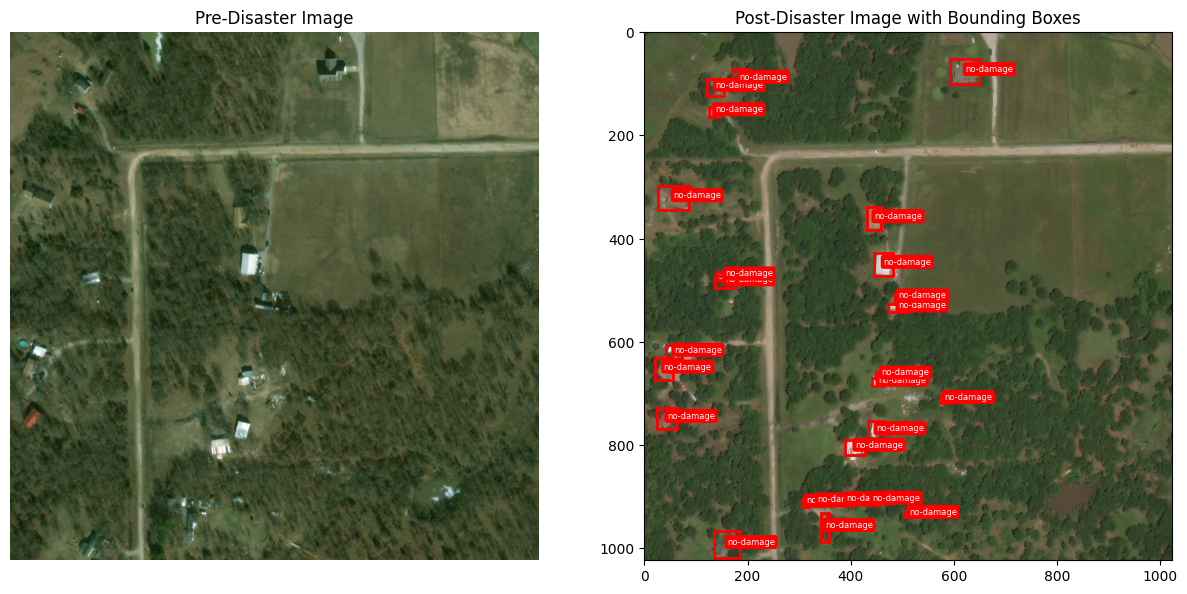

In [4]:


# Randomly select an index from the training dataset
id = random.choice(range(len(merged_tr)))  # Examples: 1195, 1350, 999, 1450

# Retrieve image paths, bounding boxes, and labels for the selected sample
image_pre, images_post, bboxes, sh = merged_tr.loc[id]

# Reverse the label mapping to get category names from numeric labels
reverse_map = {v: k for k, v in LABEL_MAP.items()}
sh = [reverse_map[val] for val in sh]  # Convert label IDs to category names

# Print selected image index for reference
print(id)

# Display the pre- and post-disaster images with bounding boxes
plot_image_with_boxes(image_pre, images_post, bboxes, sh, use_rectangles)


# **Create DataLoader**

In [5]:
# =========================================
# Custom Dataset Loader for Disaster Images
# =========================================

class DataLoader(torch.utils.data.Dataset):
    def __init__(self, dataframe, categories, transforms=None, format_name='pascal_voc'):
        """
        Initializes the dataset loader.

        Args:
        - dataframe: Pandas DataFrame containing image paths, bounding boxes, and labels.
        - categories: List of damage categories.
        - transforms: Optional data augmentation transformations.
        - format_name: Bounding box format ('pascal_voc', 'yolo', 'coco', 'albumentations').
        """
        self.data = dataframe
        self.categories = categories
        self.transforms = transforms
        self.format_name = format_name  # Define bounding box format

    def __getitem__(self, idx): 
        """
        Retrieves a single sample from the dataset.

        Args:
        - idx: Index of the sample.

        Returns:
        - image: Concatenated pre- and post-disaster images.
        - target: Dictionary containing bounding boxes and labels.
        """
        img_pre, img_post, bboxes, labels = self.data.iloc[idx]

        # Load and normalize pre-disaster image
        img_pre = cv2.imread(img_pre, cv2.IMREAD_COLOR)
        img_pre = cv2.cvtColor(img_pre, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        
        # Load and normalize post-disaster image
        img_post = cv2.imread(img_post, cv2.IMREAD_COLOR)
        img_post = cv2.cvtColor(img_post, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        
        # Convert bounding boxes to the specified format
        img_h, img_w, _ = img_pre.shape
        bboxes = [self.convert_bbox(bbox, img_w, img_h, to_format=self.format_name) for bbox in bboxes]
        
        # Apply transformations if provided
        if self.transforms is not None:
            sample_pre = self.transforms(image=img_pre, bboxes=bboxes, labels=labels)
            sample_post = self.transforms(image=img_post, bboxes=bboxes, labels=labels)
        
        # Convert bounding boxes and labels to tensors
        norm_boxes = torch.as_tensor(sample_post['bboxes'], dtype=torch.float32)
        labels = torch.as_tensor(sample_post['labels'], dtype=torch.int64)

        # Create target dictionary
        target = {'labels': labels, 'boxes': norm_boxes}

        # Concatenate pre- and post-disaster images along the channel dimension
        image = torch.cat((sample_pre['image'], sample_post['image']), dim=0)
        return image, target
    
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.data)

    @staticmethod
    def convert_bbox(bbox, img_w, img_h, to_format='pascal_voc'):
        """
        Converts bounding box coordinates to different formats.

        Args:
        - bbox: List of [xmin, ymin, xmax, ymax] in Pascal VOC format.
        - img_w: Image width.
        - img_h: Image height.
        - to_format: Target bounding box format.

        Returns:
        - Converted bounding box in the specified format.
        """
        xmin, ymin, xmax, ymax = bbox

        if to_format == 'pascal_voc':
            return [xmin, ymin, xmax, ymax]  # No change
        
        elif to_format == 'yolo':
            x_center = (xmin + xmax) / (2 * img_w)
            y_center = (ymin + ymax) / (2 * img_h)
            width = (xmax - xmin) / img_w
            height = (ymax - ymin) / img_h
            return [x_center, y_center, width, height]
        
        elif to_format == 'coco':
            width = xmax - xmin
            height = ymax - ymin
            return [xmin, ymin, width, height]
        
        elif to_format == 'albumentations':
            return [xmin / img_w, ymin / img_h, xmax / img_w, ymax / img_h]
        
        else:
            raise ValueError(f"Unsupported format: {to_format}")


### Helper Functions to visualize sample from the Dataloader

In [6]:
# ===================================
# Bounding Box Conversion & Plotting
# ===================================

def convert_bbox_for_plotting(bboxes, img_w, img_h, from_format):
    """
    Converts bounding boxes from different formats to Pascal VOC (xmin, ymin, xmax, ymax) for visualization.

    Args:
    - bboxes: List of bounding boxes in the given format.
    - img_w: Image width.
    - img_h: Image height.
    - from_format: Original format of bounding boxes ('pascal_voc', 'yolo', 'coco', 'albumentations').

    Returns:
    - Torch tensor of bounding boxes in Pascal VOC format.
    """
    converted_bboxes = []
    
    for bbox in bboxes:
        if from_format == 'pascal_voc':
            converted_bboxes.append(bbox.numpy())  # No change
        
        elif from_format == 'yolo':
            x_center, y_center, width, height = bbox
            xmin = (x_center - width / 2) * img_w
            ymin = (y_center - height / 2) * img_h
            xmax = (x_center + width / 2) * img_w
            ymax = (y_center + height / 2) * img_h
            converted_bboxes.append([xmin, ymin, xmax, ymax])
        
        elif from_format == 'coco':
            xmin, ymin, width, height = bbox
            xmax = xmin + width
            ymax = ymin + height
            converted_bboxes.append([xmin, ymin, xmax, ymax])
        
        elif from_format == 'albumentations':
            xmin, ymin, xmax, ymax = bbox
            converted_bboxes.append([xmin * img_w, ymin * img_h, xmax * img_w, ymax * img_h])
        
        else:
            raise ValueError(f"Unsupported format: {from_format}")

    return torch.tensor(converted_bboxes, dtype=torch.float32)

def plot_img_bbox(img, target, format_name='yolo'):
    """
    Plots pre- and post-disaster images with bounding boxes.

    Args:
    - img: Tensor containing concatenated pre- and post-disaster images.
    - target: Dictionary containing bounding boxes and labels.
    - format_name: Format of the bounding boxes ('pascal_voc', 'yolo', 'coco', 'albumentations').
    """
    pre_img = img[:3, ...].permute(1, 2, 0).numpy()
    post_img = img[3:, ...].permute(1, 2, 0).numpy()
    
    img_h, img_w, _ = post_img.shape
    converted_bboxes = convert_bbox_for_plotting(target['boxes'], img_w, img_h, format_name)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Pre-Disaster Image
    axes[0].imshow(pre_img)
    axes[0].set_title("Pre-Disaster Image")
    axes[0].axis("off")

    # Post-Disaster Image with Bounding Boxes
    axes[1].imshow(post_img)
    axes[1].set_title("Post-Disaster Image with Bounding Boxes")
    axes[1].axis("off")

    for box in converted_bboxes:
        xmin, ymin, xmax, ymax = box.tolist()
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                 linewidth=2, edgecolor='r', facecolor='none')
        axes[1].add_patch(rect)

    plt.show()


### Create Dataloader and Plot sample

/tmp/ipykernel_348844/2772417578.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(converted_bboxes, dtype=torch.float32)


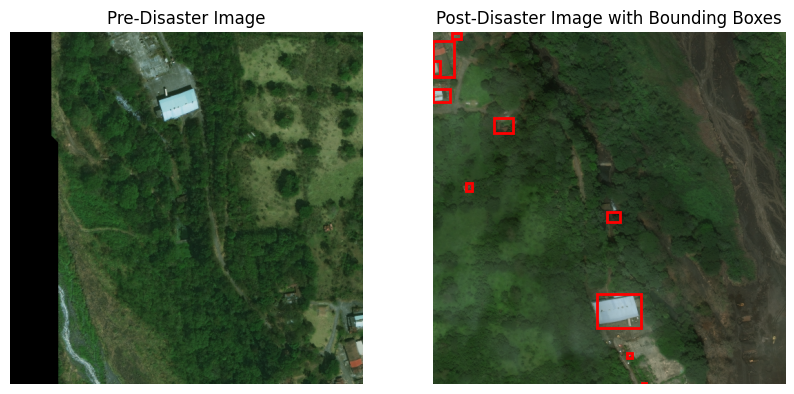

In [7]:
# Define bounding box format
bboxes_type = 'pascal_voc'  # Options: 'yolo', 'albumentations', 'coco', 'pascal_voc'

# Define image size
size = 512


# Define training transformation pipeline
train_transform = Alb.Compose([
    Alb.HorizontalFlip(p=0.5),
    Alb.Resize(height=size, width=size, p=1),
    Alb.VerticalFlip(p=0.5),
    ToTensorV2(p=1.0)
], bbox_params=Alb.BboxParams(format=bboxes_type, label_fields=['labels']))

# Define validation transformation pipeline
valid_transform = Alb.Compose([
    ToTensorV2(p=1.0)
], bbox_params=Alb.BboxParams(format=bboxes_type, label_fields=['labels']))

# Create DataLoader
dl = DataLoader(
    dataframe=merged_tr,
    categories=["no-damage", "minor-damage", "major-damage", "destroyed"],
    format_name=bboxes_type,
    transforms=train_transform
)

# Fetch a sample from DataLoader
it = iter(dl)
out = next(it) 

# Plot the sample image with bounding boxes
plot_img_bbox(out[0], out[1], format_name=bboxes_type)


# **Train**

# Load the Model

In [8]:
num_classes = 5  # 4 damage categories + 1 background

# Load SSD300 with pretrained weights
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

# Modify classification head
in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
num_anchors = model.anchor_generator.num_anchors_per_location()
model.head.classification_head = SSDClassificationHead(
    in_channels=in_channels, num_anchors=num_anchors, num_classes=num_classes
)

# Adjust input image normalization
new_mean = [0.485, 0.456, 0.406] * 2  # Repeat for 6 channels
new_std = [0.229, 0.224, 0.225] * 2  # Repeat for 6 channels

# Modify backbone first layer to accept 6-channel images
model.backbone.features[0] = nn.Conv2d(
    in_channels=6, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True
)

# Update transform
model.transform = GeneralizedRCNNTransform(
    min_size=size, max_size=size, image_mean=new_mean, image_std=new_std
)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Print model summary
print(model)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

### Initialize the parameters, dataloaders, optimizer, scheduler

In [9]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.0001)


# To monitor training loss
train_loss_hist = utils_.Averager()


### Create dataloader

In [10]:
train_loader = DataLoader(dataframe = merged_tr , categories = ["no-damage","minor-damage", "major-damage", "destroyed"], 
                           transforms = train_transform) 

valid_loader = DataLoader(dataframe = merged_ts , categories = ["no-damage","minor-damage", "major-damage", "destroyed"], 
                            transforms = valid_transform) 

data_loader = torch.utils.data.DataLoader(
    train_loader, batch_size=8, shuffle=False, collate_fn=utils_.collate_fn, num_workers=0)

data_loader_test = torch.utils.data.DataLoader(
    valid_loader, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils_.collate_fn)

In [11]:
losses_tr   = {"loss": [], "bbox_regression":[], "classification":[]}
losses_ts   = {"loss": [], "bbox_regression":[], "classification":[]}
map_50_list = []
map_list    = []
save_each   = 1
num_epochs = 20


scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 0.000375, epochs=num_epochs, steps_per_epoch=len(data_loader),
        cycle_momentum=True, three_phase=False, base_momentum=0.85, max_momentum=0.95, last_epoch=-1,
        div_factor=num_epochs * 1000, anneal_strategy='linear', final_div_factor=num_epochs,
    )

# Training and monitoring results

In [12]:
def train_test(train_data_loader, model, DEVICE = "cuda" if  torch.cuda.is_available() else "cpu", training = True):
    print('Training') if training else  print('Testing')
    returns = {"loss": [], "bbox_regression":[], "classification":[]}
    model.train()
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        #print(targets)
        images = list(image.to(DEVICE) for image in images)
        targets =  [{k: torch.tensor(v).to(DEVICE) for k, v in t.items()} for t in targets] #[{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
       
        loss_dict = model(images, targets)

        #print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        returns["loss"].append(losses.detach().cpu().numpy().tolist())
        for i in loss_dict:
            returns[i].append(loss_dict[i].detach().cpu().numpy().tolist())
        if training : 
            losses.backward()
            optimizer.step()
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return returns

In [13]:
def validate(valid_data_loader, model, DEVICE = "cuda" if  torch.cuda.is_available() else "cpu",):
    print('Validating')
    model.eval()
    
    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: torch.tensor(v).to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

In [14]:

for epoch in range(num_epochs):
    print(f"\nEPOCH {epoch+1} of {num_epochs}")
    
    # Start timer and carry out training and validation.
    start = time.time()

    #Train And Loss Print
    losses  = train_test(data_loader, model)
    for i, (loss_name, loss_data) in enumerate(losses.items()):
        losses_tr[loss_name] += loss_data
    print(f"Epoch #{epoch+1} train loss: {np.mean(losses['loss'])}") 

    #Test And Loss Print
    losses = train_test(data_loader_test, model, training = False)
    for i, (loss_name, loss_data) in enumerate(losses.items()):
        losses_ts[loss_name] += loss_data
    print(f"Epoch #{epoch+1} train loss: {np.mean(losses['loss'])}") 

    #Evaluation and Model Save  this is will done according to the numer of save_each
    if epoch%save_each  == 0 :
        metric_summary = validate(data_loader_test, model)
        print(f"Epoch #{epoch+1} mAP: {metric_summary['map']}")   
    
        map_50_list.append(metric_summary['map_50'])
        map_list.append(metric_summary['map'])
        os.makedirs('./save', exist_ok=True)
        torch.save(model.state_dict(),f"./save/Model_epoch-{epoch}_map50-{str(metric_summary['map_50'].numpy())[:5]}.pth")

    scheduler.step()
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")


loss_tr_df = pd.DataFrame(losses_tr)
loss_ts_df = pd.DataFrame(losses_ts)
loss_tr_df.to_csv('./save/loss_train.csv')
loss_ts_df.to_csv('./save/loss_valid.csv')


EPOCH 1 of 20
Training


  0%|          | 0/286 [00:00<?, ?it/s]/tmp/ipykernel_348844/2880168287.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets =  [{k: torch.tensor(v).to(DEVICE) for k, v in t.items()} for t in targets] #[{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
Loss: 15.5843: 100%|██████████| 286/286 [03:05<00:00,  1.54it/s]


Epoch #1 train loss: 17.370039112918025
Testing


Loss: 18.2206: 100%|██████████| 752/752 [01:01<00:00, 12.29it/s]


Epoch #1 train loss: 20.080081664501353
Validating


  0%|          | 0/752 [00:00<?, ?it/s]/tmp/ipykernel_348844/3894731495.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(DEVICE) for k, v in t.items()} for t in targets]
100%|██████████| 752/752 [01:00<00:00, 12.44it/s]
/home/rcam/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoch #1 mAP: 3.069796150612092e-07
Took 5.668 minutes for epoch 0

EPOCH 2 of 20
Training


Loss: 11.8670: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s]


Epoch #2 train loss: 14.926554416443084
Testing


Loss: 13.7995: 100%|██████████| 752/752 [01:01<00:00, 12.28it/s]


Epoch #2 train loss: 14.861332356929779
Validating


100%|██████████| 752/752 [01:00<00:00, 12.50it/s]


Epoch #2 mAP: 4.1886511326083564e-07
Took 5.472 minutes for epoch 1

EPOCH 3 of 20
Training


Loss: 10.8092: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s]


Epoch #3 train loss: 12.828209586910434
Testing


Loss: 12.3482: 100%|██████████| 752/752 [01:00<00:00, 12.34it/s]


Epoch #3 train loss: 13.06503231855149
Validating


100%|██████████| 752/752 [01:00<00:00, 12.46it/s]


Epoch #3 mAP: 5.984942163195228e-06
Took 5.889 minutes for epoch 2

EPOCH 4 of 20
Training


Loss: 10.6659: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s]


Epoch #4 train loss: 11.988779551499373
Testing


Loss: 11.6462: 100%|██████████| 752/752 [01:01<00:00, 12.31it/s]


Epoch #4 train loss: 12.26143016143048
Validating


100%|██████████| 752/752 [01:00<00:00, 12.43it/s]


Epoch #4 mAP: 1.0960272902593715e-06
Took 5.955 minutes for epoch 3

EPOCH 5 of 20
Training


Loss: 9.7797: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s] 


Epoch #5 train loss: 11.407440622369727
Testing


Loss: 11.0469: 100%|██████████| 752/752 [01:01<00:00, 12.32it/s]


Epoch #5 train loss: 11.622566179392186
Validating


100%|██████████| 752/752 [01:00<00:00, 12.42it/s]


Epoch #5 mAP: 0.0002481878036633134
Took 5.910 minutes for epoch 4

EPOCH 6 of 20
Training


Loss: 9.6544: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s] 


Epoch #6 train loss: 10.84822513673689
Testing


Loss: 10.4287: 100%|██████████| 752/752 [01:01<00:00, 12.20it/s]


Epoch #6 train loss: 10.997615810404433
Validating


100%|██████████| 752/752 [01:00<00:00, 12.43it/s]


Epoch #6 mAP: 8.378793427255005e-05
Took 5.927 minutes for epoch 5

EPOCH 7 of 20
Training


Loss: 9.0399: 100%|██████████| 286/286 [03:05<00:00,  1.55it/s] 


Epoch #7 train loss: 10.27098423617703
Testing


Loss: 9.8836: 100%|██████████| 752/752 [01:00<00:00, 12.39it/s] 


Epoch #7 train loss: 10.442421193452592
Validating


100%|██████████| 752/752 [01:00<00:00, 12.49it/s]


Epoch #7 mAP: 1.1371093933121301e-05
Took 5.907 minutes for epoch 6

EPOCH 8 of 20
Training


Loss: 8.2877: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s] 


Epoch #8 train loss: 9.752903744890974
Testing


Loss: 9.4244: 100%|██████████| 752/752 [01:01<00:00, 12.24it/s] 


Epoch #8 train loss: 9.961121321992671
Validating


100%|██████████| 752/752 [01:00<00:00, 12.48it/s]


Epoch #8 mAP: 0.0002979024138767272
Took 5.921 minutes for epoch 7

EPOCH 9 of 20
Training


Loss: 8.1259: 100%|██████████| 286/286 [03:05<00:00,  1.54it/s] 


Epoch #9 train loss: 9.323283965771015
Testing


Loss: 9.0204: 100%|██████████| 752/752 [01:01<00:00, 12.25it/s] 


Epoch #9 train loss: 9.573310055631273
Validating


100%|██████████| 752/752 [01:00<00:00, 12.39it/s]


Epoch #9 mAP: 0.0003727318544406444
Took 5.932 minutes for epoch 8

EPOCH 10 of 20
Training


Loss: 7.4843: 100%|██████████| 286/286 [03:05<00:00,  1.54it/s] 


Epoch #10 train loss: 8.96102166009116
Testing


Loss: 8.6719: 100%|██████████| 752/752 [01:01<00:00, 12.32it/s] 


Epoch #10 train loss: 9.223460243103352
Validating


100%|██████████| 752/752 [01:00<00:00, 12.43it/s]


Epoch #10 mAP: 0.0003115418367087841
Took 5.945 minutes for epoch 9

EPOCH 11 of 20
Training


Loss: 7.2905: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s] 


Epoch #11 train loss: 8.608846549387579
Testing


Loss: 8.3417: 100%|██████████| 752/752 [01:00<00:00, 12.34it/s] 


Epoch #11 train loss: 8.898134563831572
Validating


100%|██████████| 752/752 [01:00<00:00, 12.47it/s]


Epoch #11 mAP: 0.00017873194883577526
Took 5.927 minutes for epoch 10

EPOCH 12 of 20
Training


Loss: 6.7639: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s] 


Epoch #12 train loss: 8.294885528671157
Testing


Loss: 8.0449: 100%|██████████| 752/752 [01:01<00:00, 12.27it/s] 


Epoch #12 train loss: 8.628038802045458
Validating


100%|██████████| 752/752 [01:00<00:00, 12.43it/s]


Epoch #12 mAP: 0.0001243834849447012
Took 5.947 minutes for epoch 11

EPOCH 13 of 20
Training


Loss: 6.5286: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s] 


Epoch #13 train loss: 8.043072675491546
Testing


Loss: 7.7557: 100%|██████████| 752/752 [01:00<00:00, 12.33it/s] 


Epoch #13 train loss: 8.381706258718003
Validating


100%|██████████| 752/752 [01:00<00:00, 12.49it/s]


Epoch #13 mAP: 0.00033726837136782706
Took 5.937 minutes for epoch 12

EPOCH 14 of 20
Training


Loss: 6.1645: 100%|██████████| 286/286 [03:03<00:00,  1.56it/s] 


Epoch #14 train loss: 7.810661807760492
Testing


Loss: 7.5255: 100%|██████████| 752/752 [01:00<00:00, 12.35it/s] 


Epoch #14 train loss: 8.17999150144293
Validating


100%|██████████| 752/752 [01:00<00:00, 12.49it/s]


Epoch #14 mAP: 0.001510133151896298
Took 5.917 minutes for epoch 13

EPOCH 15 of 20
Training


Loss: 6.0790: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s] 


Epoch #15 train loss: 7.6195056871934375
Testing


Loss: 7.3191: 100%|██████████| 752/752 [01:01<00:00, 12.27it/s] 


Epoch #15 train loss: 8.001267300641283
Validating


100%|██████████| 752/752 [01:00<00:00, 12.46it/s]


Epoch #15 mAP: 0.0015349123859778047
Took 5.933 minutes for epoch 14

EPOCH 16 of 20
Training


Loss: 6.0891: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s] 


Epoch #16 train loss: 7.467197436552781
Testing


Loss: 7.1398: 100%|██████████| 752/752 [01:00<00:00, 12.34it/s] 


Epoch #16 train loss: 7.860763410938547
Validating


100%|██████████| 752/752 [01:00<00:00, 12.48it/s]


Epoch #16 mAP: 0.0015054324176162481
Took 5.919 minutes for epoch 15

EPOCH 17 of 20
Training


Loss: 5.7995: 100%|██████████| 286/286 [03:04<00:00,  1.55it/s] 


Epoch #17 train loss: 7.327731127505536
Testing


Loss: 7.0110: 100%|██████████| 752/752 [01:01<00:00, 12.25it/s] 


Epoch #17 train loss: 7.743679315485853
Validating


100%|██████████| 752/752 [01:00<00:00, 12.44it/s]


Epoch #17 mAP: 0.0015942590544000268
Took 5.920 minutes for epoch 16

EPOCH 18 of 20
Training


Loss: 5.6136: 100%|██████████| 286/286 [03:02<00:00,  1.56it/s] 


Epoch #18 train loss: 7.231459074087076
Testing


Loss: 6.8588: 100%|██████████| 752/752 [01:00<00:00, 12.43it/s] 


Epoch #18 train loss: 7.631167798600298
Validating


100%|██████████| 752/752 [00:59<00:00, 12.56it/s]


Epoch #18 mAP: 0.00183157529681921
Took 5.866 minutes for epoch 17

EPOCH 19 of 20
Training


Loss: 5.4716: 100%|██████████| 286/286 [03:03<00:00,  1.56it/s] 


Epoch #19 train loss: 7.139526553920932
Testing


Loss: 6.6861: 100%|██████████| 752/752 [01:00<00:00, 12.37it/s] 


Epoch #19 train loss: 7.54361728531249
Validating


100%|██████████| 752/752 [01:00<00:00, 12.50it/s]


Epoch #19 mAP: 0.002112570684403181
Took 5.884 minutes for epoch 18

EPOCH 20 of 20
Training


Loss: 5.5352: 100%|██████████| 286/286 [03:03<00:00,  1.56it/s] 


Epoch #20 train loss: 7.062897903935893
Testing


Loss: 6.6125: 100%|██████████| 752/752 [01:00<00:00, 12.34it/s] 


Epoch #20 train loss: 7.456817924976349
Validating


100%|██████████| 752/752 [01:00<00:00, 12.46it/s]


Epoch #20 mAP: 0.0022494716104120016
Took 5.885 minutes for epoch 19


# Plot the Loss Progress

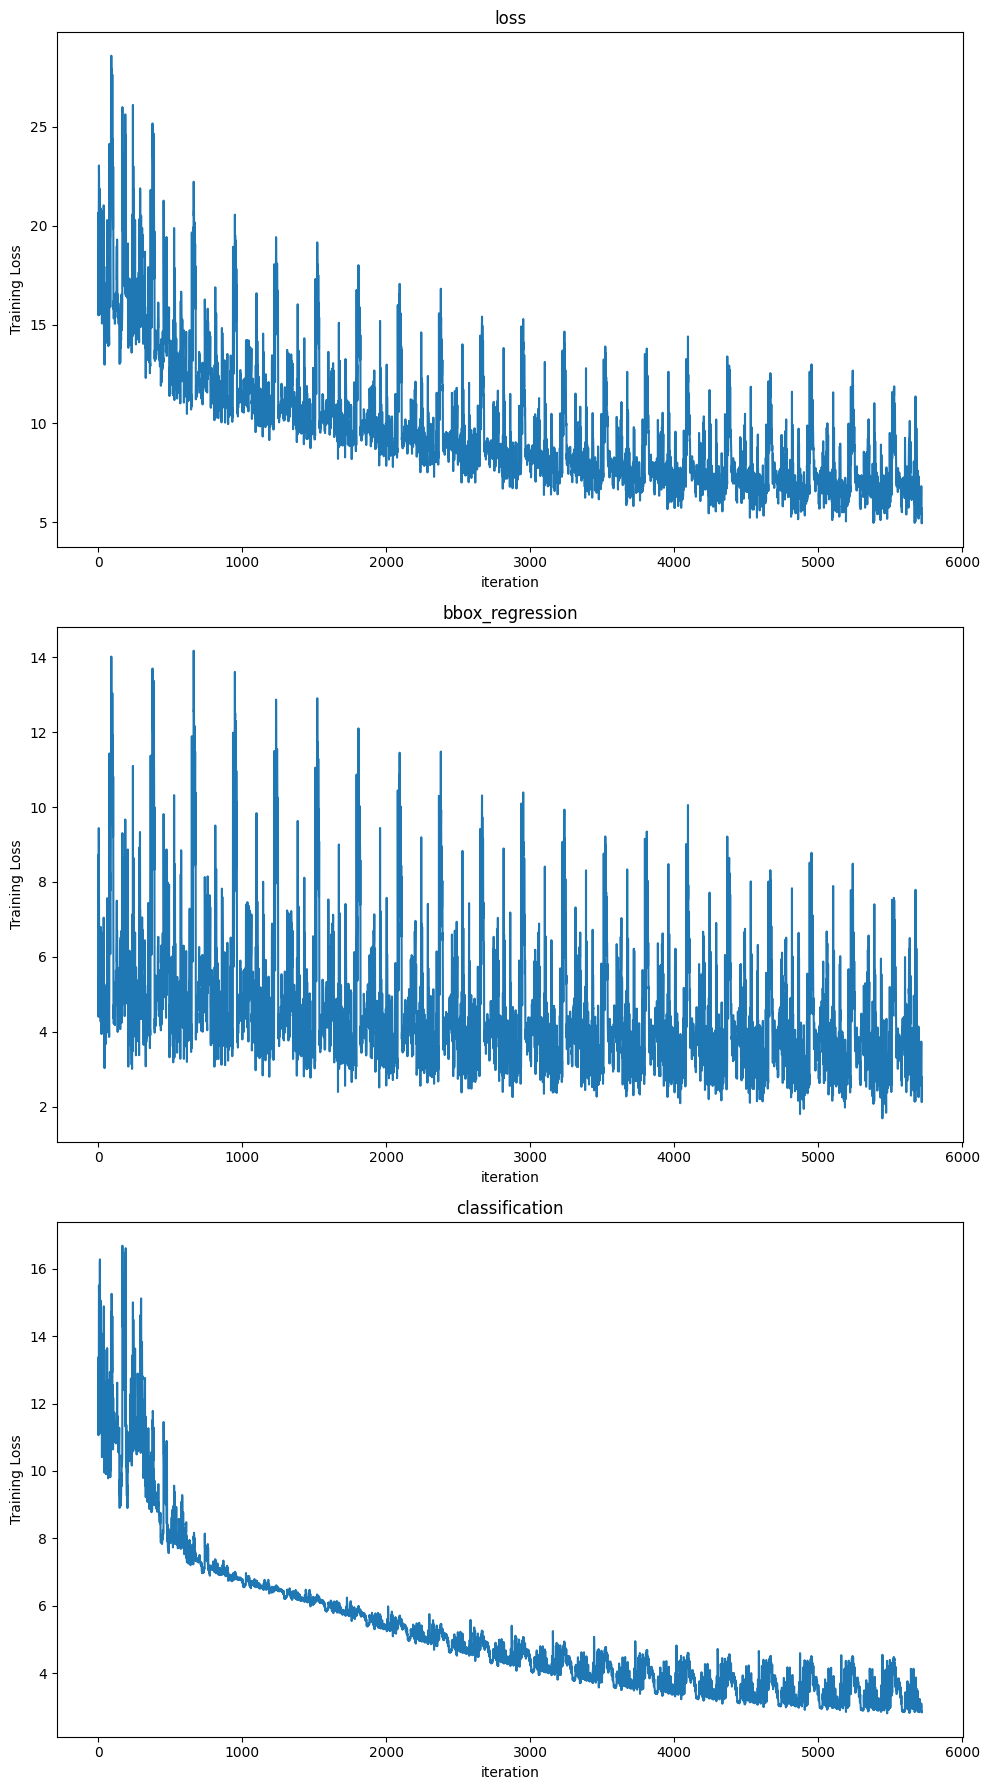

In [15]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                num_losses = len(losses_tr)

# Create subplots
fig, axes = plt.subplots(num_losses, 1, figsize=(10, 6*num_losses))
# Plot each loss separately
for i, (loss_name, loss_data) in enumerate(losses_tr.items()):
    #concatenated_losses = [loss for epoch_losses in loss_data for loss in epoch_losses]
    ax = axes[i] if num_losses > 1 else axes  # Handle single subplot case
    ax.plot(loss_data)
    ax.set_xlabel('iteration')
    ax.set_ylabel('Training Loss')
    ax.set_title(loss_name)

plt.tight_layout()
plt.show()

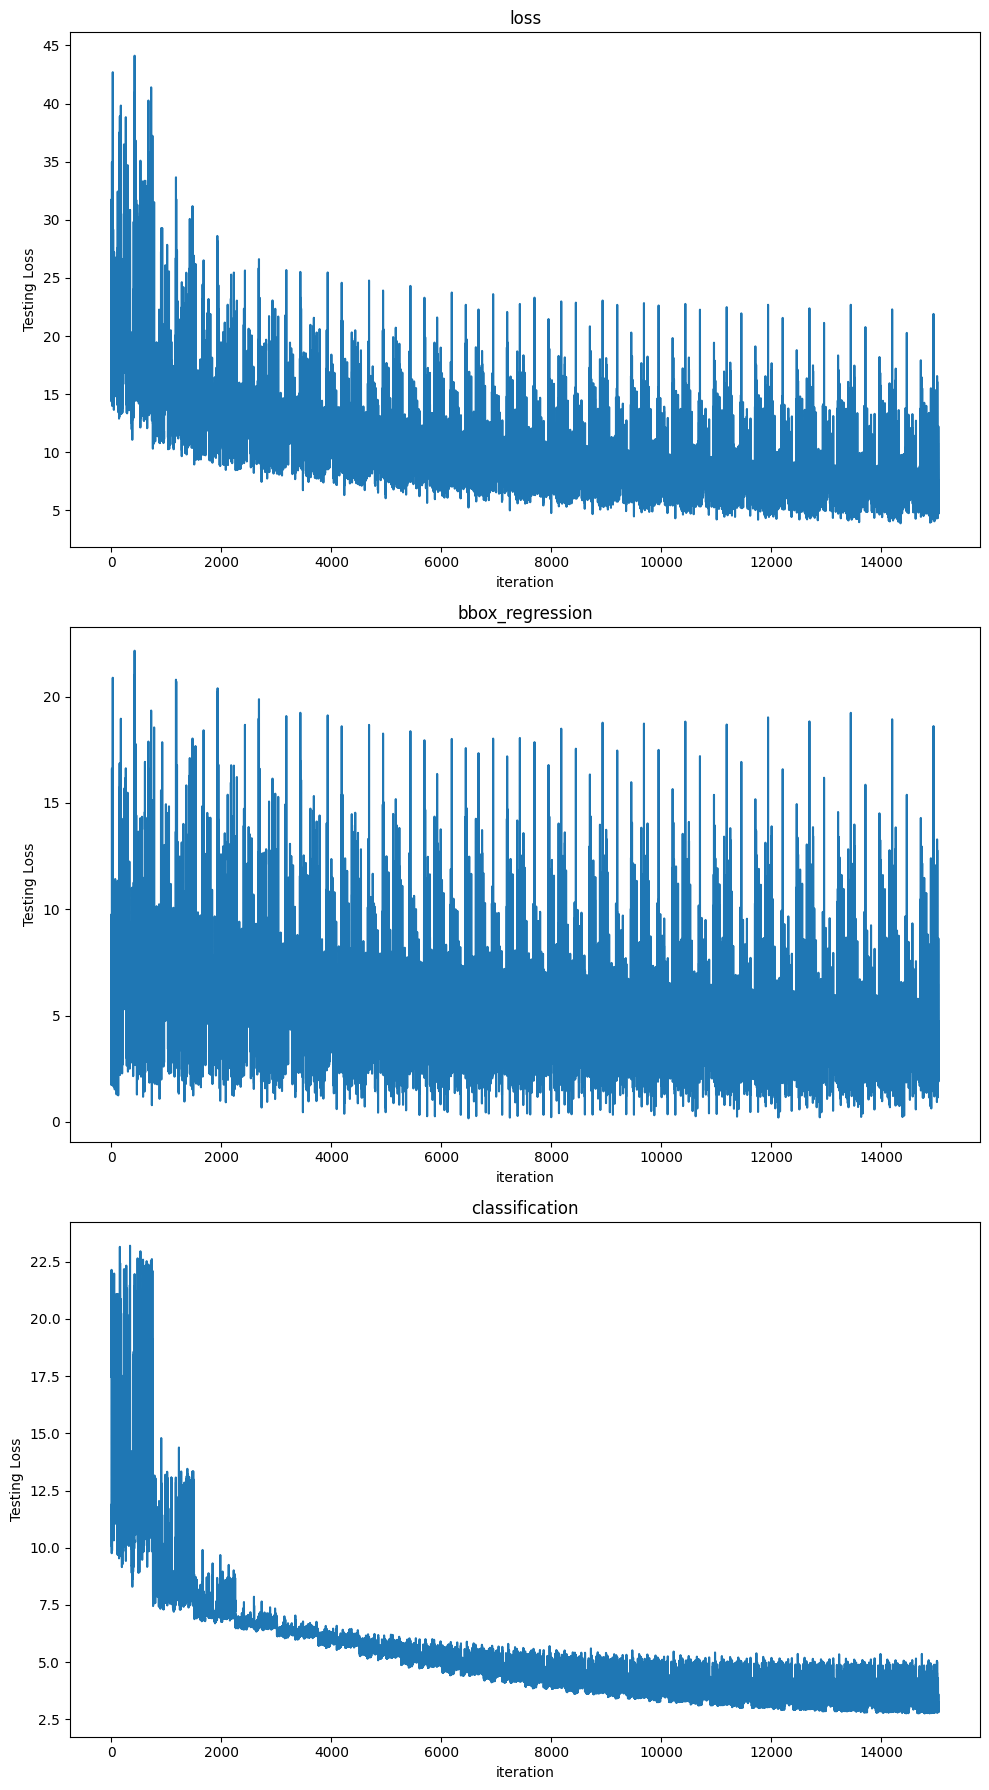

In [16]:
#def plot_loss(losses)
num_losses = len(losses_ts)

# Create subplots
fig, axes = plt.subplots(num_losses, 1, figsize=(10, 6*num_losses))
# Plot each loss separately
for i, (loss_name, loss_data) in enumerate(losses_ts.items()):
    #concatenated_losses = [loss for epoch_losses in loss_data for loss in epoch_losses]
    ax = axes[i] if num_losses > 1 else axes  # Handle single subplot case
    ax.plot(loss_data)
    ax.set_xlabel('iteration')
    ax.set_ylabel('Testing Loss')
    ax.set_title(loss_name)

plt.tight_layout()
plt.show()

# **Visualize the Predection with Threshold**

In [17]:
# the function takes the original prediction and the iou threshold.
def plot_image_with_boxes(image, detections,  thresh = None):
    """
    Plot image with bounding boxes and labels if the score is higher than 0.7.
    
    Args:
    - image: Torch tensor representing the image.
    - detections: Dictionary containing 'boxes', 'labels', and 'scores'.
    """
    # Convert image from torch tensor to numpy array
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    if thresh  == None : thresh = 0.0
    # Create figure and axis
    fig, ax = plt.subplots(1)

    # Plot the image
    ax.imshow(image_np)

    # Loop through each detection
    for box, label, score in zip(detections['boxes'], detections['labels'], detections['scores']):
        # Only plot if the score is higher than 0.7
        if score > thresh:
            # Get box coordinates
            xmin, ymin, xmax, ymax = box

            # Calculate box width and height
            width = xmax - xmin
            height = ymax - ymin

            # Create a Rectangle patch
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

            # Add label and score
            plt.text(xmin, ymin, f'{label}: {score:.2f}', color='b', fontsize=8, verticalalignment='bottom')

    # Show plot
    plt.show()

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [26]:
model.load_state_dict(torch.load("./save/Model_epoch-6_map50-9.646.pth"))

<All keys matched successfully>

predicted #boxes:  200
real #boxes:  36


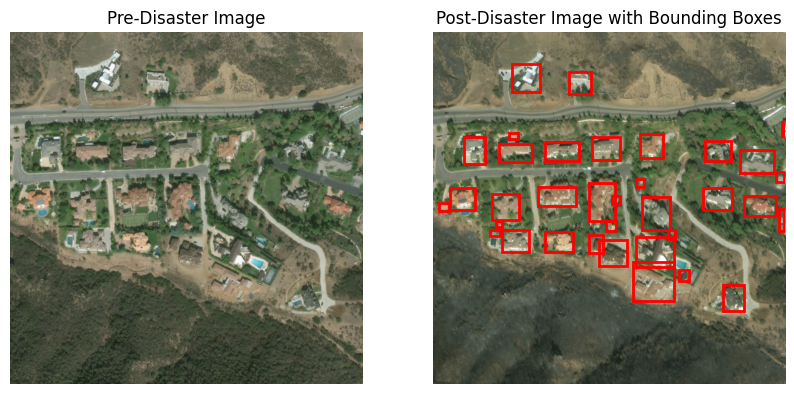

In [30]:
device =  "cuda" if  torch.cuda.is_available() else "cpu"
# pick one image from the test set
img, target = valid_loader[random.choice(range(len(valid_loader)))]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))
plot_img_bbox(img, target, format_name='pascal_voc')

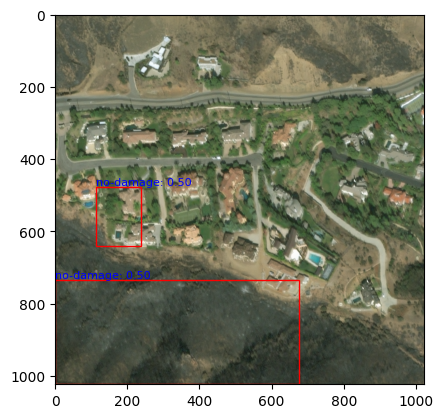

In [44]:
out = {}
for i in prediction:
    out[i] = prediction[i].cpu()
nms_prediction = apply_nms(out, iou_thresh=0.9)
nms_prediction['labels'] = [i - 1 for i in nms_prediction['labels'].tolist()]
nms_prediction['labels'] = [key for val in nms_prediction['labels'] for key, ref_val in LABEL_MAP.items() if ref_val == val] 
plot_image_with_boxes(img[3:,...], nms_prediction, thresh=0.5)